# Lab 01 :  Diffusion Model (DM) for Mixture of Gaussians -- solution


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5242_2025_codes/labs_lecture08/lab01_dm_gmm'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd


Mounted at /content/gdrive
/content/gdrive/My Drive/CS5242_2025_codes/labs_lecture08/lab01_dm_gmm
/content/gdrive/My Drive/CS5242_2025_codes/labs_lecture08/lab01_dm_gmm


In [2]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time
#import utils
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings
import os, datetime

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:0") # use GPU
else:
  device= torch.device("cpu")
print(device)


2.6.0+cu124
Tesla T4
cuda:0


# Create artifical dataset of mixture of Gaussians

num_x, range_x, step_x, x :  100 20 0.40404040404040403 torch.Size([100])
num_gaussians :  2
train_data, bs, num_batch :  torch.Size([4000, 100]) 100 40
train_data :  torch.Size([4000, 100])
max, min, mean :  tensor(1.) tensor(-1.) tensor(-0.7510)


<Figure size 640x480 with 0 Axes>

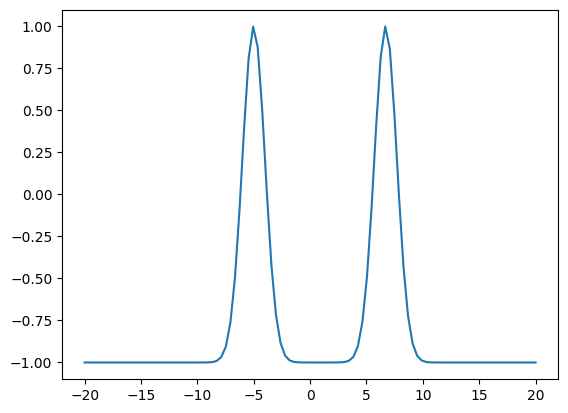

<Figure size 640x480 with 0 Axes>

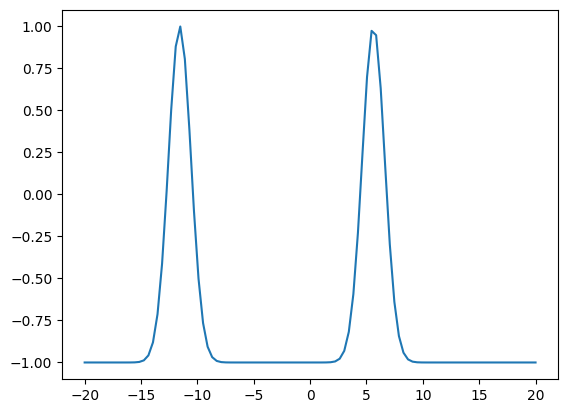

In [3]:
# Parameters of the mixture of Gaussians
num_data = 4000
num_x = 100
range_x = 20
step_x = 2 * range_x / (num_x - 1)
x = torch.arange(-range_x,range_x+step_x,step_x)  #x is a 1D array of 100 points evenly spaced from -20 to 20
print('num_x, range_x, step_x, x : ',num_x, range_x, step_x, x.size())
num_gaussians = 2
print('num_gaussians : ', num_gaussians)
train_data = torch.zeros(num_data, num_x)
bs = 100
num_batch = num_data//bs # 40 batch
print('train_data, bs, num_batch : ', train_data.size(), bs, num_batch)

for k in range(num_batch): # for each one of the 40 batches
    mu = torch.zeros(num_gaussians, bs) # bs=100 points/curves will be generated
    mu[0,:] = torch.FloatTensor(bs).uniform_(-15, -5) # they have modes around -15,-5
    mu[1,:] = torch.FloatTensor(bs).uniform_(5, 15)
    mu_batch = mu.unsqueeze(2)
    sigma = torch.ones(num_gaussians, bs)
    sigma_batch = sigma.unsqueeze(2)
    x_batch = x.repeat(num_gaussians, bs, 1)
    p = torch.exp( - (x_batch - mu_batch)**2 / (2* sigma_batch**2) ) / torch.sqrt( 2* torch.pi* sigma_batch**2 )
    p = p.sum(0); p /= p.sum(1).unsqueeze(1)
    p = ( p - p.min(1)[0].unsqueeze(1) ) / ( p.max(1)[0].unsqueeze(1) - p.min(1)[0].unsqueeze(1) )
    p = 2 * ( p - 0.5 )
    train_data[k*bs:(k+1)*bs, :] = p
print('train_data : ',train_data.size())
print('max, min, mean : ',train_data.max(), train_data.min(), train_data.mean())

plt.figure(2)
plt.figure(dpi=100)
plt.plot(x, train_data[0])
plt.show()
plt.figure(3)
plt.figure(dpi=100)
plt.plot(x, train_data[1])
plt.show()


# Diffusion model (DDPM) and Transformers


In [4]:
# Global constants
N = train_data.size(0) # number of training data
n = train_data.size(1) # number of elements in the line
print('N, n : ', N, n)

# transformer setting
num_heads = 4 # number of heads in the transformer layer
d = 32 * num_heads # number of hidden dimensions
num_layers = 4 # number of transformer layers
dPEt = d # number of dimensions for the time step of the diffusion model
drop = 0.01 # dropout value
bs = 50 # batch size
print('num_heads, d, num_layers, dPEt, drop, bs : ', num_heads, d, num_layers, dPEt, drop, bs)

# diffusion setting
beta_1 = 0.0001 # beta_1 for DM
beta_T = 0.02 # beta_T for DM
num_t = 150 # number of time steps of the DM
alpha_t = 1.0 - torch.linspace(beta_1, beta_T, num_t).to(device) # for DM, size=[num_t]
alpha_bar_t = torch.cumprod( alpha_t, dim=0) # for DM, size=[num_t]
print('beta_1, beta_T, num_t :', beta_1, beta_T, num_t)


N, n :  4000 100
num_heads, d, num_layers, dPEt, drop, bs :  4 128 4 128 0.01 50
beta_1, beta_T, num_t : 0.0001 0.02 150


In [5]:
# Define DDPM architecture with Transformers

# This defines one attention head
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
    def forward(self, x):
        Q = self.Q(x)      # [bs, n, d_head]
        K = self.K(x)      # [bs, n, d_head]
        V = self.V(x)      # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        Att = (Q * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)        # [bs, n, n]
        Att = self.drop_att(Att) # [bs, n, d_head]
        x = Att @ V              # [bs, n, d_head]
        return x

# multi-head attention
#Each head runs its own attention independently.
#Concatenate outputs of all heads.
#Apply a final linear layer (WOx) to mix them.

class MHA(nn.Module):
    def __init__(self, d, num_heads):
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
    def forward(self, x):
        x_MHA = []
        for head in self.heads:
            x_HA = head(x)                    # [bs, n, d_head]
            x_MHA.append(x_HA)
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)                    # [bs, n, d]
        return x

#One full Transformer block:
#Layer Norm before attention.
#Apply Multi-Head Attention (MHA).
#Add residual connection (skip connection).
#Then another Layer Norm.
#Apply a small MLP (feedforward) after attention.
#Another residual connection.
#It stacks self-attention + MLP, just like in standard Transformer encoder blocks.


class BlockGT(nn.Module):
    def __init__(self, d, num_heads):
        super().__init__()
        self.LNx = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)
        self.MHA = MHA(d, num_heads)
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))
        self.drop_x_mlp = nn.Dropout(drop)
        self.mu = nn.Linear(d, d, bias=True)
    def forward(self, x):
        x_in = x                        # [bs, n, d]
        x = self.LNx(x)                 # [bs, n, d]
        x_MHA = self.MHA(x)             # [bs, n, d]
        x = x_in + x_MHA                # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]
        x = self.drop_x_mlp(x)          # [bs, n, d]
        return x


#This is the core DDPM model:
#Input: a noisy sample x_t and its time step t.
#Goal: predict the denoised version (or the noise) at the next step.


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pe_t_emb = nn.Sequential(nn.Embedding(num_t, dPEt), nn.ReLU(), nn.Linear(dPEt, d)) #embeds the diffusion time t.
        self.pe_x = nn.Embedding(n, d) #Add positional encoding (self.pe_x) to know where we are along the x-axis.
        self.x_emb = nn.Linear(1, d) #projects the input (x_t) (which is real numbers) into a high-dimensional vector (d dimensions).
        self.gt_layers = nn.ModuleList( [BlockGT(d, num_heads) for _ in range(num_layers)] ) #apply the block
        self.ln_final = nn.LayerNorm(d) #Final layer norm (ln_final)
        self.linear_final = nn.Linear(d, 1) #Linear layer to predict output: from high dimension back to scalar values per x-point.
        self.drop_x_emb = nn.Dropout(drop)
        self.drop_p_emb = nn.Dropout(drop)
    def forward(self, x_t, sample_t):
        x_t = self.x_emb(x_t.unsqueeze(2)) # [bs, n, d]
        bs2 = x_t.size(0)
        pe_x = torch.arange(0,n).to(device).repeat(bs2,1) # [bs, n]
        pe_x = self.pe_x(pe_x)             # [bs, n, d]
        x_t = x_t + pe_x                   # [bs, n, d]
        p_t = self.pe_t_emb(sample_t)      # [bs, d]
        x_t = self.drop_x_emb(x_t)         # [bs, n, d]
        p_t = self.drop_p_emb(p_t)         # [bs, d]
        for gt_layer in self.gt_layers:
            x_t = x_t + p_t.unsqueeze(1)   # [bs, n, d]
            x_t = gt_layer(x_t)            # [bs, n, d]
        # output
        x_t = self.ln_final(x_t)           # [bs, n, d]
        x_t_minus_one = self.linear_final(x_t).squeeze()  # [bs, n]
        return x_t_minus_one

# Question 1: Implement the DDPM architecture

#### Step 1: Define the weights $\alpha_t$ and $\bar{\alpha_t}$
- Their lengths are the same as the number of timesteps $T$.

#### Step 2: Code the forward diffusion process
- Jump from $x_0$ to $x_t$ in one step.
\begin{eqnarray*}
    x_t = \sqrt{\bar{\alpha_t}}x_0+\sqrt{1-\bar{\alpha_t}}\epsilon_0, \textrm{where } \epsilon_0\sim\mathcal{N}(0, I)
\end{eqnarray*}

#### Step 3: Implement the backward denosing process
Given the current step sample $x_t$ and $t$, predict the noise $\epsilon$ with a transformer network.

#### Step 4: Code the generation process
- Randomly sample from $x_T\sim\mathcal{N}(0, I)$.
- Generate $x_{t-1}$ given $x_t$ following the distribution $p(x_{t-1}|x_t, x_0)=\mathcal{N}(\mu_t, \sigma_t^2)$, where:
\begin{eqnarray*}
    &&\mu_t = \frac{1}{\sqrt{\alpha_t}}(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}
    \epsilon_\theta(x_t, t)),\\
    &&\sigma^2_t = \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha_t}}\\
    \textrm{So, } &&x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}
    \epsilon_\theta(x_t, t))+\sigma_t z, \textrm{where } z\sim\mathcal{N}(0, I).
\end{eqnarray*}
We recurrently calculate $x_{t-1}$ until $x_0$.


In [6]:
#This defines the DDPM (Denoising Diffusion Probabilistic Model) logic:
#Forward process: add noise
#Backward process: remove noise (denoise)
#Sampling: generate new data starting from pure noise
#It uses the UNet (the Transformer-based model you defined earlier) to predict noise at each time step.

class DDPM(nn.Module):

    #initialize DDPM
    def __init__(self, num_t, beta_1, beta_T):
        super().__init__()
        self.num_t = num_t
        self.alpha_t = 1.0 - torch.linspace(beta_1, beta_T, num_t).to(device) # [num_t]
        self.alpha_bar_t = torch.cumprod( self.alpha_t, dim=0) # [num_t]
        self.UNet = UNet() #Creates the denoising model: UNet (Transformer-based model).

    # forward_process: Add noise to the data
    def forward_process(self, x0, sample_t, noise_x0): # Given: x0: clean data., sample_t: time step t, noise_x0: sampled Gaussian noise.
    # It produces a noisy version x_t at time t
        bs2 = len(sample_t)
        sqrt_alpha_bar_t = self.alpha_bar_t[sample_t].sqrt()                     # [bs]
        sqrt_one_minus_alpha_bar_t = ( 1.0 - self.alpha_bar_t[sample_t] ).sqrt() # [bs]
        x_t = sqrt_alpha_bar_t.view(bs2,1) * x0 + sqrt_one_minus_alpha_bar_t.view(bs2,1) * noise_x0 # [bs, n]
        return x_t

    # backward_process: Predict noise from noisy data
    def backward_process(self, x_t, sample_t): #Given: x_t: noisy data at time t, sample_t: time step.
    #It passes x_t and sample_t through the UNet to predict the noise:
        noise_pred_x_t = self.UNet(x_t, sample_t) # [bs, n]
        return noise_pred_x_t

    def generate_process_ddpm(self, num_mol):
        t = num_t - 1
        bs = num_mol
        batch_t = (t * torch.ones(bs)).long().to(device) #Start from pure Gaussian noise at final time T
        batch_x_t = torch.randn(bs, n).to(device) # t=T => t=T-1 in python
        set_t = list(range(t-1,0,-1)); set_t = set_t + [0]
        #Iteratively go backwards from t=T to t=0:
        #Predict noise using backward_process().
        #Use predicted noise to compute x_{t-1} from x_t.
        #Add a bit of fresh Gaussian noise controlled by sigma_t (optional, small noise at each step).
        for t_minus_one in set_t: # for t=T,T-step_size,T-2*step_size,...,step_size,0
            batch_t_minus_one = (t_minus_one * torch.ones(bs)).long().to(device)
            batch_noise_pred_x_t = self.backward_process(batch_x_t, batch_t) # predicted noise hat(epsilon)
            sigma_t = ( (1.0-self.alpha_bar_t[t_minus_one])/ (1.0-self.alpha_bar_t[t])* (1.0-self.alpha_bar_t[t]/self.alpha_bar_t[t_minus_one]) ).sqrt()
            c1 = self.alpha_bar_t[t_minus_one].sqrt() / self.alpha_bar_t[t].sqrt()
            c2 = ( 1.0 - self.alpha_bar_t[t] + 1e-10 ).sqrt()
            c3 = ( 1.0 - self.alpha_bar_t[t_minus_one] - sigma_t.square() + 1e-10 ).sqrt()
            batch_x_t_minus_one = c1 * ( batch_x_t - c2 * batch_noise_pred_x_t ) + \
                c3 * batch_noise_pred_x_t + sigma_t* torch.randn(bs, n).to(device)
            t = t_minus_one
            batch_x_t = batch_x_t_minus_one
            batch_t = batch_t_minus_one
        return batch_x_t

# Question 2: Code the training loss of DDPM

Hint:
- Calculate the MSE loss between the injected noise during $x_0\rightarrow x_t$ and the predicted noise. Use [torch.nn.MSELoss()](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss).


In [7]:
# Instantiate the network
net = DDPM(num_t, beta_1, beta_T) #Creates the DDPM model using the hyperparameters you defined earlier.
net = net.to(device) #Moves it to GPU if available (device).
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch

#Create optimizer and scheduler
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

# Sample a random batch of real data
idx_data = torch.LongTensor(bs).random_(0,N)
# Randomly pick bs=50 samples from your 4000 training curves (You create a mini-batch to simulate one training step.)
batch_x0 = train_data[idx_data,:].to(device) # [bs, n]
print('batch_x0',batch_x0.size())
#Sample random time steps. For each sample in the batch, randomly choose a time step t (between 0 and T-1)
#Each curve is assigned a random noise level.
batch_sample_t = torch.randint(0, num_t, (batch_x0.size(0),)).long().to(device) # random interger in {0,1,...,T-1} [bs]
print('batch_sample_t',batch_sample_t.size())
bs2, n = batch_x0.size()
#Create random Gaussian noise — same shape as the data.
batch_noise_x_t = torch.randn(bs2,n).to(device) # [bs, n]
print('batch_noise_x_t',batch_noise_x_t.size())
#Add noise to the clean batch using forward_process. Now you have noisy samples x_t corresponding to their t levels
x_t = net.forward_process(batch_x0, batch_sample_t, batch_noise_x_t) # [bs, n]
print('x_t',x_t.size())
# Use backward_process (UNet) to predict what noise was added at each timestep.
noise_pred_x_t = net.backward_process(x_t, batch_sample_t) # [bs, n]
print('noise_pred_x_t',noise_pred_x_t.size())
#Loss = mean squared error (MSE) between: 1 = predicted noise noise_pred_x_t, 2= true noise batch_noise_x_t
loss_DDPM = torch.nn.MSELoss()(noise_pred_x_t, batch_noise_x_t)
loss = loss_DDPM
# Gradient update
optimizer.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25)
optimizer.step()
#Generate new samples
with torch.no_grad():
    batch_x_0 = net.generate_process_ddpm(4) #Generate 4 brand new samples starting from pure noise using the learned model.
    print('batch_x_0',batch_x_0.size())

Number of parameters: 908289 (0.91 million)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


batch_x0 torch.Size([50, 100])
batch_sample_t torch.Size([50])
batch_noise_x_t torch.Size([50, 100])
x_t torch.Size([50, 100])
noise_pred_x_t torch.Size([50, 100])
batch_x_0 torch.Size([4, 100])


Number of parameters: 908289 (0.91 million)
epoch= 0 	 time= 0.0702 min 	 lr= 0.0003 	 loss= 0.4763
epoch= 1 	 time= 0.1411 min 	 lr= 0.0003 	 loss= 0.2913
epoch= 2 	 time= 0.2123 min 	 lr= 0.0003 	 loss= 0.2566
epoch= 3 	 time= 0.2837 min 	 lr= 0.0003 	 loss= 0.2491
epoch= 4 	 time= 0.3556 min 	 lr= 0.0003 	 loss= 0.2430
epoch= 5 	 time= 0.4280 min 	 lr= 0.0003 	 loss= 0.2347
epoch= 6 	 time= 0.5005 min 	 lr= 0.0003 	 loss= 0.2287
epoch= 7 	 time= 0.5736 min 	 lr= 0.0003 	 loss= 0.2096
epoch= 8 	 time= 0.6470 min 	 lr= 0.0003 	 loss= 0.1722
epoch= 9 	 time= 0.7207 min 	 lr= 0.0003 	 loss= 0.1481
epoch= 10 	 time= 0.7950 min 	 lr= 0.0003 	 loss= 0.1327


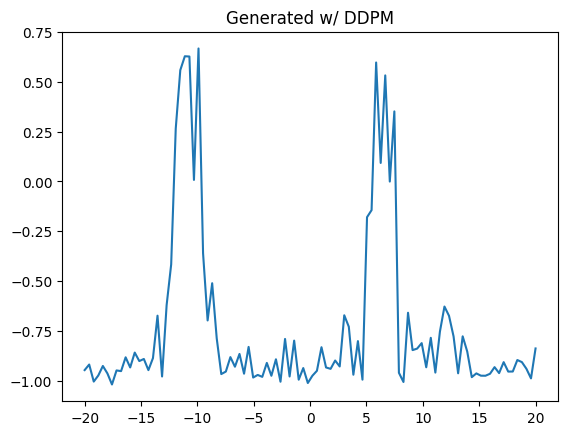

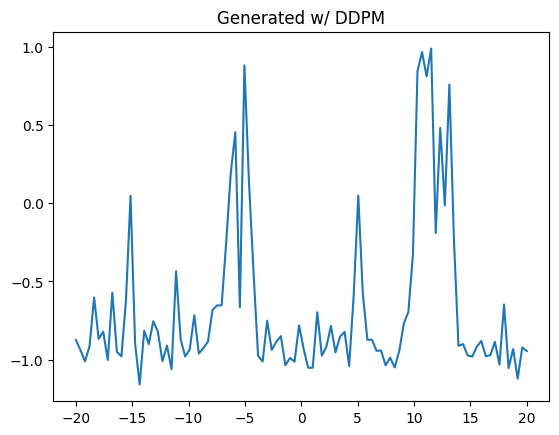

epoch= 11 	 time= 0.9012 min 	 lr= 0.0003 	 loss= 0.1239
epoch= 12 	 time= 0.9760 min 	 lr= 0.0003 	 loss= 0.1172
epoch= 13 	 time= 1.0514 min 	 lr= 0.0003 	 loss= 0.1116
epoch= 14 	 time= 1.1272 min 	 lr= 0.0003 	 loss= 0.1107
epoch= 15 	 time= 1.2032 min 	 lr= 0.0003 	 loss= 0.1039
epoch= 16 	 time= 1.2801 min 	 lr= 0.0003 	 loss= 0.1009
epoch= 17 	 time= 1.3569 min 	 lr= 0.0003 	 loss= 0.1003
epoch= 18 	 time= 1.4343 min 	 lr= 0.0003 	 loss= 0.0974
epoch= 19 	 time= 1.5118 min 	 lr= 0.0003 	 loss= 0.0937
epoch= 20 	 time= 1.5886 min 	 lr= 0.0003 	 loss= 0.0936


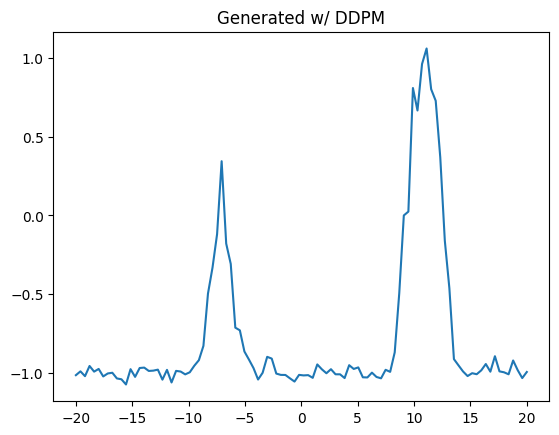

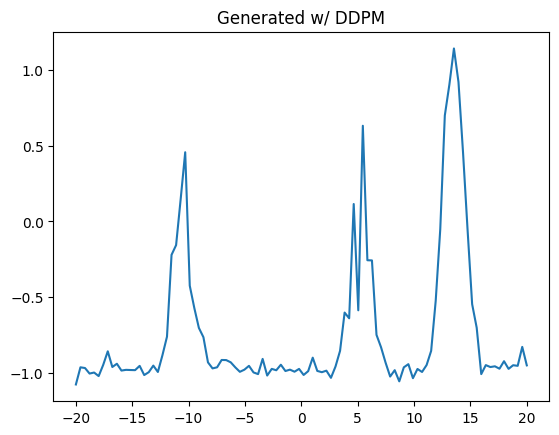

epoch= 21 	 time= 1.6909 min 	 lr= 0.0003 	 loss= 0.0919
epoch= 22 	 time= 1.7670 min 	 lr= 0.0003 	 loss= 0.0931
epoch= 23 	 time= 1.8428 min 	 lr= 0.0003 	 loss= 0.0912
epoch= 24 	 time= 1.9185 min 	 lr= 0.0003 	 loss= 0.0890
epoch= 25 	 time= 1.9940 min 	 lr= 0.0003 	 loss= 0.0939
epoch= 26 	 time= 2.0693 min 	 lr= 0.000285 	 loss= 0.0914
epoch= 27 	 time= 2.1447 min 	 lr= 0.000285 	 loss= 0.0878
epoch= 28 	 time= 2.2199 min 	 lr= 0.000285 	 loss= 0.0845
epoch= 29 	 time= 2.2952 min 	 lr= 0.000285 	 loss= 0.0852
epoch= 30 	 time= 2.3707 min 	 lr= 0.000285 	 loss= 0.0840


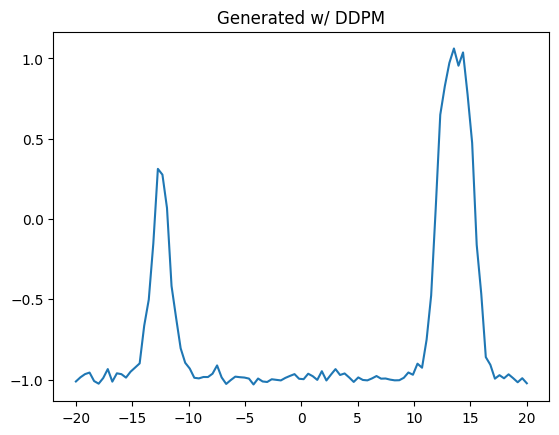

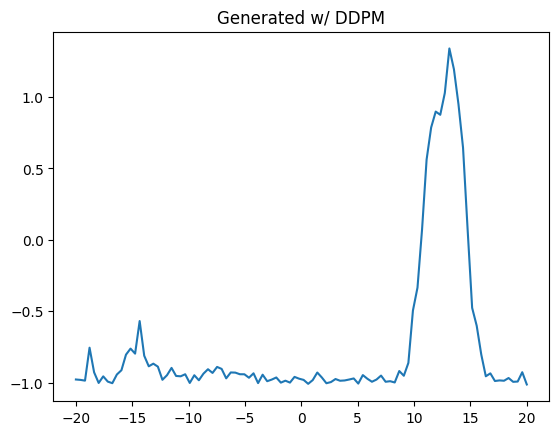

epoch= 31 	 time= 2.4681 min 	 lr= 0.000285 	 loss= 0.0868
epoch= 32 	 time= 2.5438 min 	 lr= 0.00027075 	 loss= 0.0841
epoch= 33 	 time= 2.6196 min 	 lr= 0.00027075 	 loss= 0.0840
epoch= 34 	 time= 2.6955 min 	 lr= 0.00027075 	 loss= 0.0827
epoch= 35 	 time= 2.7719 min 	 lr= 0.00027075 	 loss= 0.0817
epoch= 36 	 time= 2.8480 min 	 lr= 0.00027075 	 loss= 0.0810
epoch= 37 	 time= 2.9242 min 	 lr= 0.00027075 	 loss= 0.0846
epoch= 38 	 time= 3.0008 min 	 lr= 0.00027075 	 loss= 0.0794
epoch= 39 	 time= 3.0770 min 	 lr= 0.00027075 	 loss= 0.0818
epoch= 40 	 time= 3.1532 min 	 lr= 0.0002572125 	 loss= 0.0808


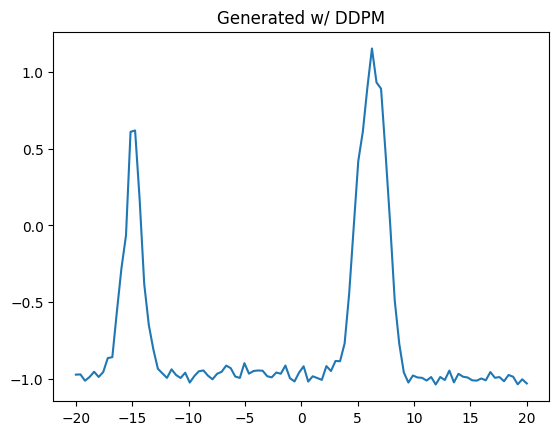

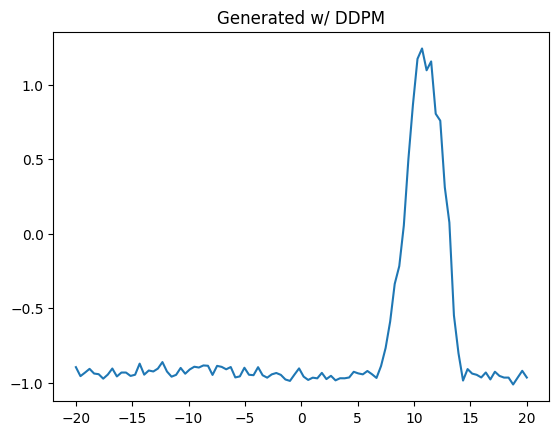

epoch= 41 	 time= 3.2601 min 	 lr= 0.0002572125 	 loss= 0.0782
epoch= 42 	 time= 3.3360 min 	 lr= 0.0002572125 	 loss= 0.0785
epoch= 43 	 time= 3.4121 min 	 lr= 0.000244351875 	 loss= 0.0784
epoch= 44 	 time= 3.4879 min 	 lr= 0.000244351875 	 loss= 0.0813
epoch= 45 	 time= 3.5638 min 	 lr= 0.000244351875 	 loss= 0.0779
epoch= 46 	 time= 3.6397 min 	 lr= 0.000244351875 	 loss= 0.0805
epoch= 47 	 time= 3.7154 min 	 lr= 0.00023213428124999998 	 loss= 0.0797
epoch= 48 	 time= 3.7911 min 	 lr= 0.00023213428124999998 	 loss= 0.0764
epoch= 49 	 time= 3.8670 min 	 lr= 0.00023213428124999998 	 loss= 0.0773
epoch= 50 	 time= 3.9427 min 	 lr= 0.00022052756718749997 	 loss= 0.0767


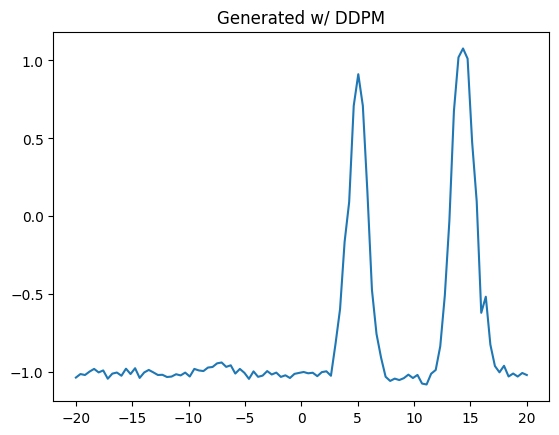

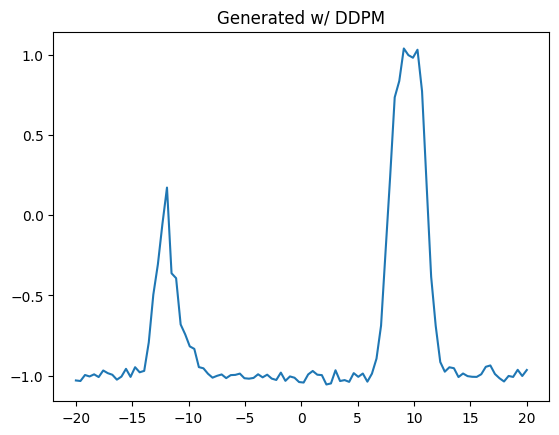

epoch= 51 	 time= 4.0441 min 	 lr= 0.00022052756718749997 	 loss= 0.0746
epoch= 52 	 time= 4.1200 min 	 lr= 0.00022052756718749997 	 loss= 0.0755
epoch= 53 	 time= 4.1959 min 	 lr= 0.00020950118882812497 	 loss= 0.0758
epoch= 54 	 time= 4.2721 min 	 lr= 0.00020950118882812497 	 loss= 0.0765
epoch= 55 	 time= 4.3482 min 	 lr= 0.00019902612938671872 	 loss= 0.0752
epoch= 56 	 time= 4.4243 min 	 lr= 0.00019902612938671872 	 loss= 0.0746
epoch= 57 	 time= 4.5007 min 	 lr= 0.00019902612938671872 	 loss= 0.0733
epoch= 58 	 time= 4.5769 min 	 lr= 0.00019902612938671872 	 loss= 0.0709
epoch= 59 	 time= 4.6529 min 	 lr= 0.00019902612938671872 	 loss= 0.0733
epoch= 60 	 time= 4.7291 min 	 lr= 0.00018907482291738277 	 loss= 0.0731


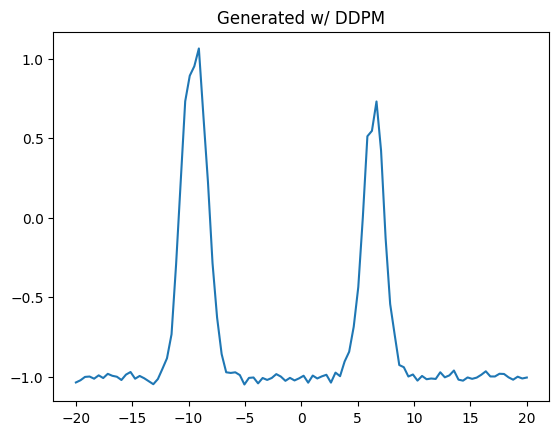

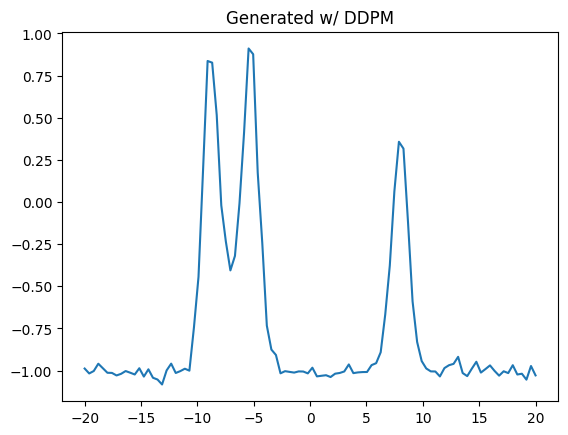

epoch= 61 	 time= 4.8276 min 	 lr= 0.00018907482291738277 	 loss= 0.0726
epoch= 62 	 time= 4.9037 min 	 lr= 0.0001796210817715136 	 loss= 0.0740
epoch= 63 	 time= 4.9795 min 	 lr= 0.0001796210817715136 	 loss= 0.0739
epoch= 64 	 time= 5.0554 min 	 lr= 0.00017064002768293793 	 loss= 0.0730
epoch= 65 	 time= 5.1314 min 	 lr= 0.00017064002768293793 	 loss= 0.0712
epoch= 66 	 time= 5.2071 min 	 lr= 0.00016210802629879103 	 loss= 0.0722
epoch= 67 	 time= 5.2829 min 	 lr= 0.00016210802629879103 	 loss= 0.0713
epoch= 68 	 time= 5.3590 min 	 lr= 0.00016210802629879103 	 loss= 0.0708
epoch= 69 	 time= 5.4347 min 	 lr= 0.00016210802629879103 	 loss= 0.0696
epoch= 70 	 time= 5.5105 min 	 lr= 0.00016210802629879103 	 loss= 0.0721


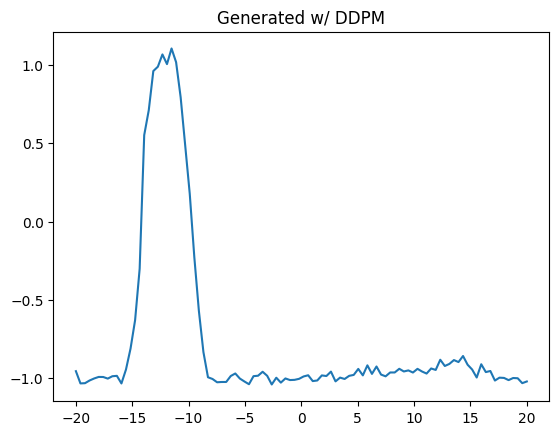

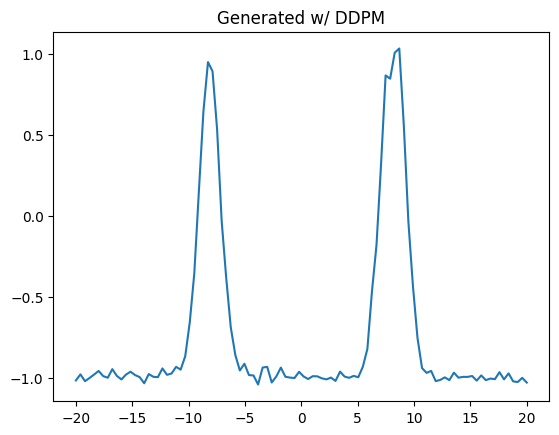

epoch= 71 	 time= 5.6158 min 	 lr= 0.00015400262498385146 	 loss= 0.0723
epoch= 72 	 time= 5.6916 min 	 lr= 0.00015400262498385146 	 loss= 0.0685
epoch= 73 	 time= 5.7675 min 	 lr= 0.00015400262498385146 	 loss= 0.0707
epoch= 74 	 time= 5.8435 min 	 lr= 0.00014630249373465888 	 loss= 0.0711
epoch= 75 	 time= 5.9194 min 	 lr= 0.00014630249373465888 	 loss= 0.0708
epoch= 76 	 time= 5.9955 min 	 lr= 0.00013898736904792593 	 loss= 0.0691
epoch= 77 	 time= 6.0714 min 	 lr= 0.00013898736904792593 	 loss= 0.0684
epoch= 78 	 time= 6.1474 min 	 lr= 0.00013898736904792593 	 loss= 0.0712
epoch= 79 	 time= 6.2236 min 	 lr= 0.00013203800059552963 	 loss= 0.0696
epoch= 80 	 time= 6.2997 min 	 lr= 0.00013203800059552963 	 loss= 0.0693


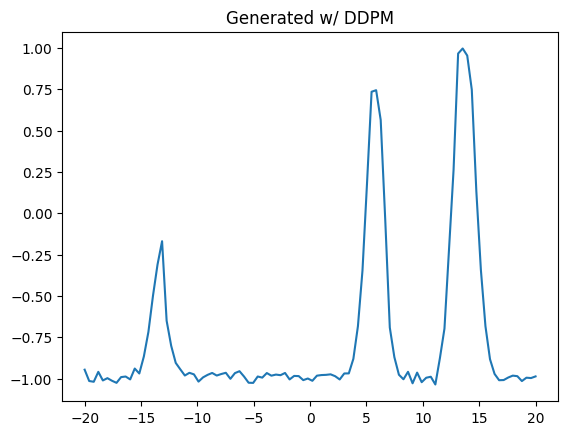

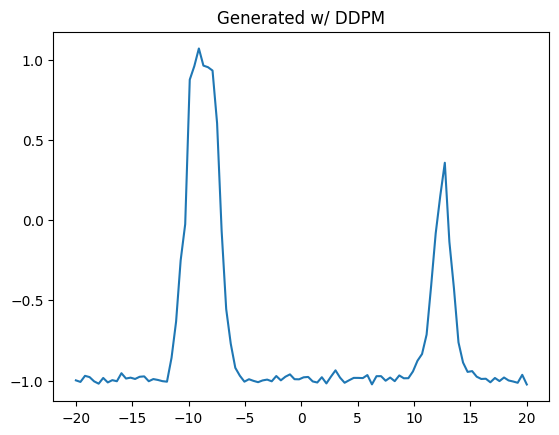

epoch= 81 	 time= 6.3988 min 	 lr= 0.00012543610056575314 	 loss= 0.0686
epoch= 82 	 time= 6.4750 min 	 lr= 0.00012543610056575314 	 loss= 0.0721
epoch= 83 	 time= 6.5510 min 	 lr= 0.00011916429553746547 	 loss= 0.0706
epoch= 84 	 time= 6.6273 min 	 lr= 0.00011916429553746547 	 loss= 0.0671
epoch= 85 	 time= 6.7034 min 	 lr= 0.00011916429553746547 	 loss= 0.0677
epoch= 86 	 time= 6.7795 min 	 lr= 0.0001132060807605922 	 loss= 0.0684
epoch= 87 	 time= 6.8558 min 	 lr= 0.0001132060807605922 	 loss= 0.0700
epoch= 88 	 time= 6.9319 min 	 lr= 0.0001132060807605922 	 loss= 0.0666
epoch= 89 	 time= 7.0081 min 	 lr= 0.0001132060807605922 	 loss= 0.0685
epoch= 90 	 time= 7.0844 min 	 lr= 0.00010754577672256258 	 loss= 0.0674


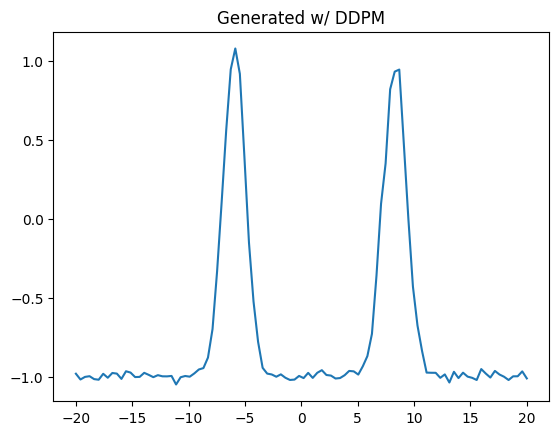

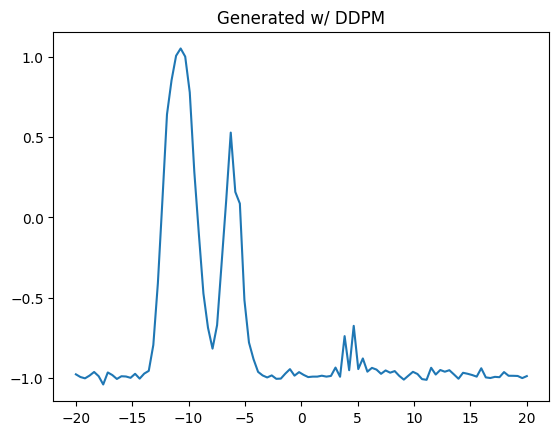

epoch= 91 	 time= 7.1832 min 	 lr= 0.00010754577672256258 	 loss= 0.0677
epoch= 92 	 time= 7.2594 min 	 lr= 0.00010754577672256258 	 loss= 0.0661
epoch= 93 	 time= 7.3357 min 	 lr= 0.00010754577672256258 	 loss= 0.0670
epoch= 94 	 time= 7.4118 min 	 lr= 0.00010216848788643445 	 loss= 0.0680
epoch= 95 	 time= 7.4880 min 	 lr= 0.00010216848788643445 	 loss= 0.0683
epoch= 96 	 time= 7.5643 min 	 lr= 0.00010216848788643445 	 loss= 0.0659
epoch= 97 	 time= 7.6404 min 	 lr= 0.00010216848788643445 	 loss= 0.0649
epoch= 98 	 time= 7.7166 min 	 lr= 0.00010216848788643445 	 loss= 0.0663
epoch= 99 	 time= 7.7926 min 	 lr= 9.706006349211273e-05 	 loss= 0.0662

 lr is equal to min lr -- training stopped



In [8]:
# Training loop
del net
net = DDPM(num_t, beta_1, beta_T)
net = net.to(device)
_ = display_num_param(net)

# Optimizer
init_lr = 0.0003
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

# Number of mini-batches per epoch
nb_epochs = 100
start = time.time()
for epoch in range(nb_epochs):

    running_loss = 0.0
    num_batches = 0

    shuffled_indices = torch.randperm(N)
    for count in range(0,N,bs):

        idx_data = shuffled_indices[count : count+bs]
        batch_x0 = train_data[idx_data,:].to(device) # [bs, n]
        batch_sample_t = torch.randint(0, num_t, (batch_x0.size(0),)).long().to(device) # random interger in {0,1,...,T-1} [bs]
        bs2, n = batch_x0.size()
        batch_noise_x_t = torch.randn(bs2,n).to(device) # [bs, n]
        x_t = net.forward_process(batch_x0, batch_sample_t, batch_noise_x_t) # [bs, n]
        noise_pred_x_t = net.backward_process(x_t, batch_sample_t) # [bs, n]
        loss_DDPM = torch.nn.MSELoss()(noise_pred_x_t, batch_noise_x_t)
        loss = loss_DDPM
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25)
        optimizer.step()

        # Compute stats
        running_loss += loss.detach().item()
        num_batches += 1

    # Average stats
    mean_loss = running_loss/num_batches
    scheduler.step(mean_loss)
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', str(elapsed)[:6],'min', '\t lr=', optimizer.param_groups[0]['lr']  ,'\t loss=', str(mean_loss)[:6] )

    # Plot intermediate generated data
    if not epoch%10 and epoch>0: #Every 10 epochs, generate 2 fake samples and plot them
        x_fake = net.generate_process_ddpm(2)
        plt.plot(x, x_fake[0].detach().cpu()); plt.title("Generated w/ DDPM"); plt.show()
        plt.plot(x, x_fake[1].detach().cpu()); plt.title("Generated w/ DDPM"); plt.show()

    # Check lr value
    if optimizer.param_groups[0]['lr'] < 10**-4:
      print("\n lr is equal to min lr -- training stopped\n")
      break



# Question 3: Generate new data

Go through `def generate_process_ddpm(self, num_mol)`.


batch_x_0 torch.Size([16, 100])


<Figure size 1280x960 with 0 Axes>

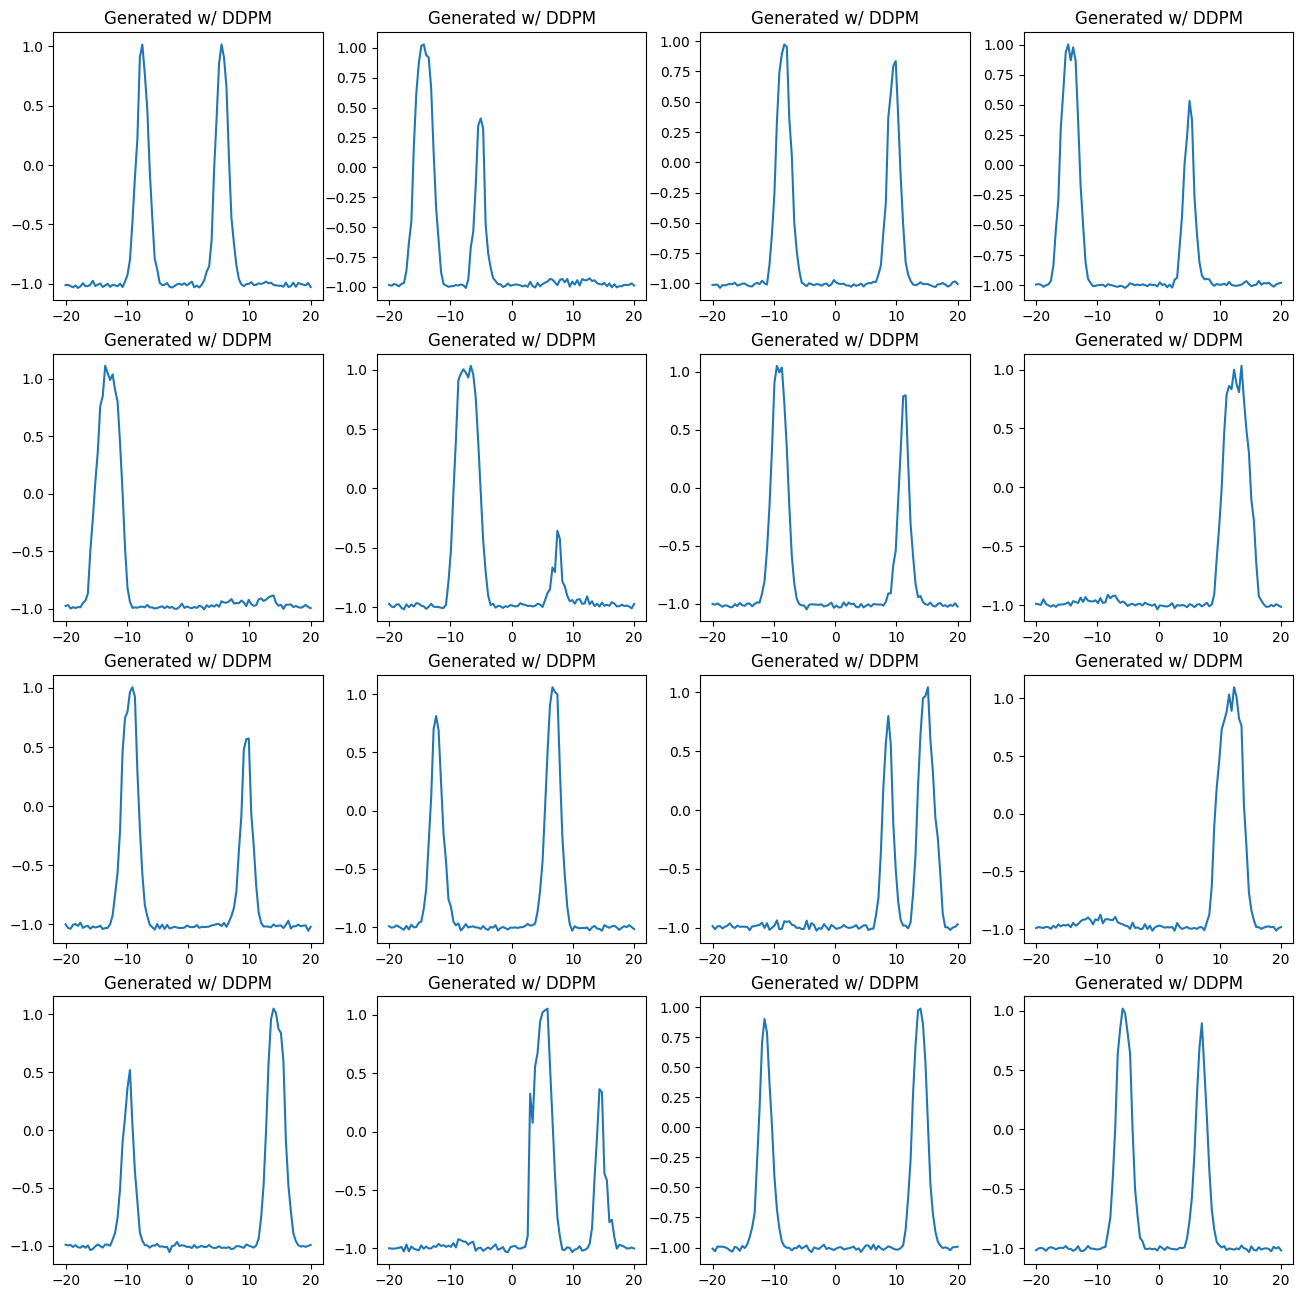

In [9]:
net.eval()
with torch.no_grad():
    num_generated_images = 16
    ###############################################
    # YOUR CODE STARTS
    ###############################################
    batch_x_0 = net.generate_process_ddpm(num_generated_images)
    ###############################################
    # YOUR CODE ENDS
    ###############################################
    print('batch_x_0',batch_x_0.size())
    batch_x_0 = batch_x_0.cpu()

plt.figure(1, dpi=200)
figure, axis = plt.subplots(4, 4)
figure.set_size_inches(16,16)
i,j,cpt=0,0,0; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=1,0,1; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=2,0,2; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=3,0,3; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=0,1+0,4; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=1,1+0,5; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=2,1+0,6; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=3,1+0,7; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=0,2+0,8; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=1,2+0,9; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=2,2+0,10; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=3,2+0,11; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=0,3+0,12; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=1,3+0,13; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=2,3+0,14; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
i,j,cpt=3,3+0,15; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ DDPM")
plt.show()
